In [2]:
import os
os.chdir("..")

In [7]:
from SSTImportanceSampling import Preprocessor, Sampler,StormDepthProcessor

In [ ]:
import SSTImportanceSampling 

In [18]:
pre = Preprocessor("/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/config.json", "/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity")
pre.run()

Processing DSS files: 100%|██████████| 9/9 [00:19<00:00,  2.22s/it]


In [6]:
pre = Preprocessor.load("/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity")

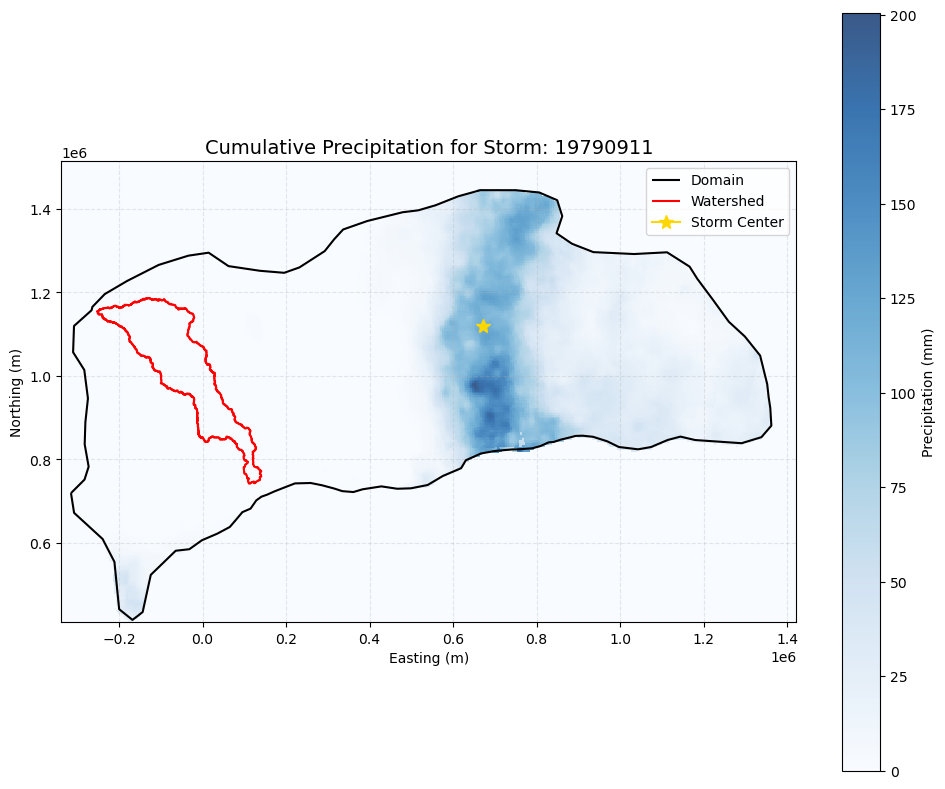

In [79]:
import matplotlib.pyplot as plt
import geopandas as gpd

def plot_storm(pre, storm_name=None):
    if storm_name is None:
        storm_name = list(pre.cumulative_precip.data_vars.keys())[0]  # pick first storm
    
    precip_da = pre.cumulative_precip[storm_name]
    watershed = pre.watershed_gdf
    domain = pre.domain_gdf
    centers_df = pre.storm_centers

    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot precipitation
    precip_da.plot.imshow(ax=ax, cmap="Blues", alpha=0.8, cbar_kwargs={'label': 'Precipitation (mm)'})

    # Plot domain and watershed
    domain.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5, label="Domain")
    watershed.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5, label="Watershed")

    # Plot storm center
    center = centers_df[centers_df["name"] == storm_name]
    ax.plot(center["x"], center["y"], marker="*", color="gold", markersize=10, label="Storm Center")

    # Labels and legend
    ax.set_title(f"Cumulative Precipitation for Storm: {storm_name}", fontsize=14)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage
plot_storm(pre, storm_name="19790911")  # or just plot_storm(pre) to pick the first storm


In [8]:
sampler = Sampler(
    distribution="uniform",
    params = {},
    num_simulations=5000,
    num_rep=5,
)

samples_df = sampler.sample(pre.domain_gdf, pre.watershed_gdf)

In [15]:
samples_df

,rep,event_id,x,y,weight
0,1,1,8.359603e+05,1.251380e+06,0.0002
1,1,2,5.128584e+05,9.219494e+05,0.0002
2,1,3,1.010478e+06,1.103647e+06,0.0002
3,1,4,6.264484e+05,1.060589e+06,0.0002
4,1,5,-6.691569e+04,1.030561e+06,0.0002
...,...,...,...,...,...
24995,5,4996,8.862389e+05,1.099586e+06,0.0002
24996,5,4997,3.414113e+05,9.431305e+05,0.0002
24997,5,4998,3.877599e+05,1.351459e+06,0.0002
24998,5,4999,6.623828e+05,1.007386e+06,0.0002


In [19]:
samples_df[samples_df["rep"] == 1]["weight"].sum()

np.float64(0.9998000399920013)

In [21]:
processor = StormDepthProcessor(
    precip_cube=pre.cumulative_precip,
    storm_centers=pre.storm_centers,
    watershed_gdf=pre.watershed_gdf,
    arrival_rate=10  # average storms per year
)

In [22]:
result_df = processor.shift_and_extract_precip(
    df_storms=samples_df,
    n_jobs=-1,     # Use all cores
    seed=42        # For reproducibility
)

In [23]:
result_df

,event_id,x,y,weight,storm_path,precip_avg_mm,rep,exc_prb,return_period
0,3983,5.288959e+04,1.134601e+06,0.0002,19790918,141.046988,1,0.0002,500.600167
1,4537,5.504225e+04,1.164144e+06,0.0002,19790918,139.508955,1,0.0004,250.550333
2,4458,1.688495e+04,1.093217e+06,0.0002,19790918,137.593080,1,0.0006,167.200500
3,2988,3.043350e+04,1.103919e+06,0.0002,19790918,137.293186,1,0.0008,125.525667
4,3743,6.288246e+04,1.174630e+06,0.0002,19790918,136.640350,1,0.0010,100.520833
...,...,...,...,...,...,...,...,...,...
24995,2227,8.277763e+05,8.636506e+05,0.0002,19790911,0.000000,5,0.9990,1.000046
24996,2230,1.018899e+06,9.686795e+05,0.0002,19790502,0.000000,5,0.9992,1.000046
24997,4151,1.252740e+06,9.061964e+05,0.0002,19790911,0.000000,5,0.9994,1.000046
24998,4156,5.500565e+05,1.371219e+06,0.0002,19790918,0.000000,5,0.9996,1.000046


In [12]:
result_df.to_csv("results.csv")

In [14]:
from scipy.stats import uniform
num_simulations = 10000
bounds = pre.domain_gdf.total_bounds
minx, miny, maxx, maxy = bounds
range_x = maxx - minx
range_y = maxy - miny

dist_x = uniform(minx, range_x)
dist_y = uniform(miny, range_y)
x = dist_x.rvs(num_simulations)
y = dist_y.rvs(num_simulations)

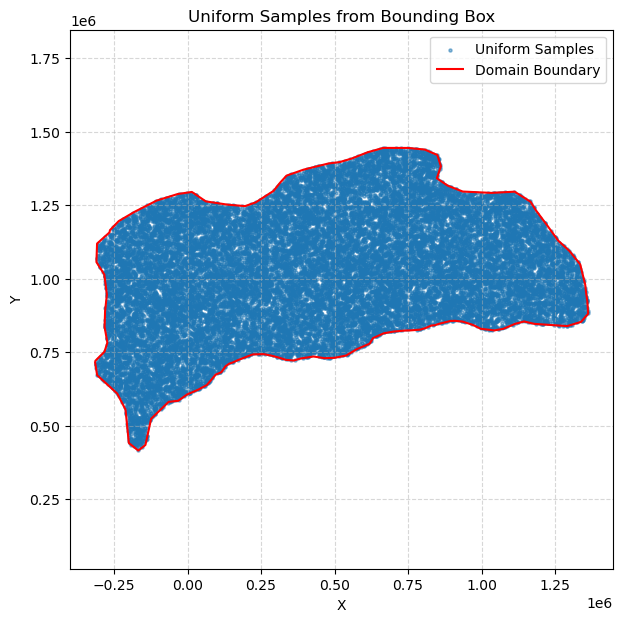

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(result_df["x"], result_df["y"], s=5, alpha=0.5, label="Uniform Samples")
pre.domain_gdf.boundary.plot(ax=plt.gca(), color='red', linewidth=1.5, label="Domain Boundary")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Uniform Samples from Bounding Box")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.axis("equal")
plt.show()